# GLM: Multivariate Linear regression

## A Motivating Example: Multivariate Linear Regression

To introduce model definition, fitting, and posterior analysis, we first consider a multivariate Bayesian linear regression model with normally-distributed priors for the parameters. We are interested in predicting outcomes $Y$ as normally-distributed observations with an expected value $\mu$ that is a linear function of two predictor variables, $X_1$ and $X_2$:

$$\begin{aligned}
Y  &\sim \mathcal{N}(\mu, \sigma^2) \\
\mu &= \alpha + \beta_1 X_1 + \beta_2 X_2
\end{aligned}$$

where $\alpha$ is the intercept, and $\beta_i$ is the coefficient for covariate $X_i$, while $\sigma$ represents the observation error. Since we are constructing a Bayesian model, we must assign a prior distribution to the unknown variables in the model. We choose zero-mean normal priors with variance of 100 for both regression coefficients, which corresponds to *weak* information regarding the true parameter values. We choose a half-normal distribution (normal distribution bounded at zero) as the prior for $\sigma$.

$$\begin{aligned}
\alpha &\sim \mathcal{N}(0, 100) \\
\beta_i &\sim \mathcal{N}(0, 100) \\
\sigma &\sim \lvert\mathcal{N}(0, 1){\rvert}
\end{aligned}$$

### Generating (true) data

We can simulate some artificial data from this model using only NumPy's {mod}`~numpy.random` module, and then use PyMC to try to recover the corresponding parameters. We are intentionally generating the data to closely correspond to the PyMC model structure.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# globals
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

Here is what the simulated data look like. We use the plotting library matplotlib to visualize the data.

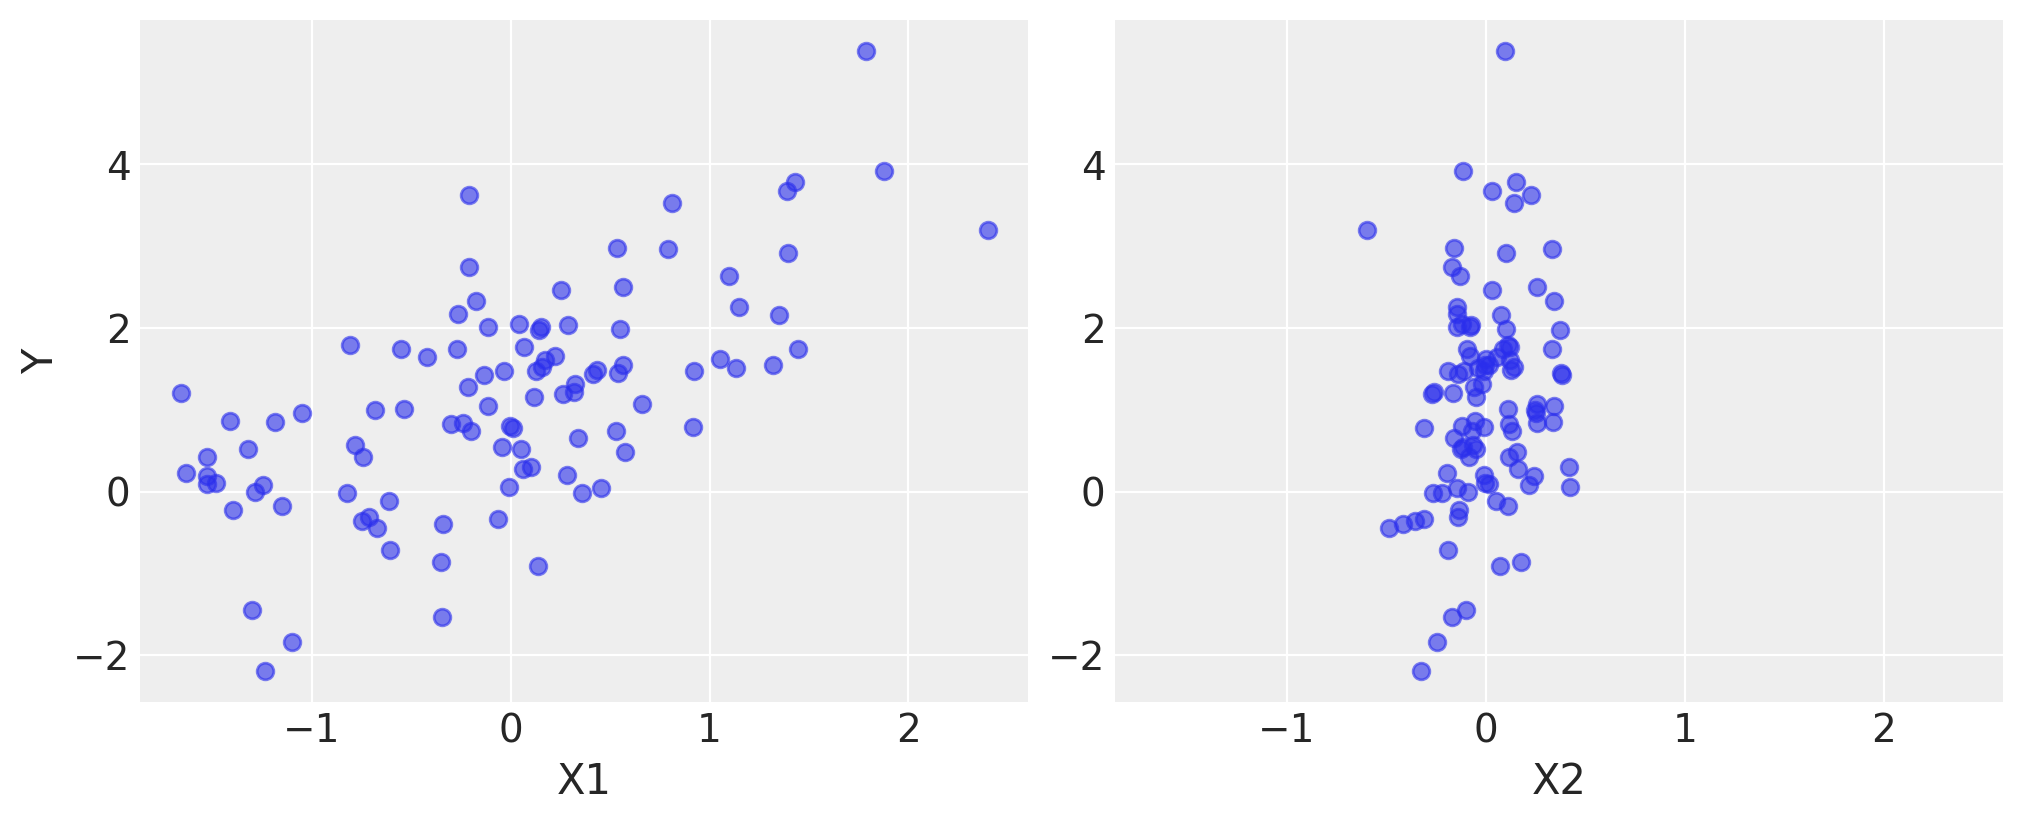

In [4]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

### Model Specification

Specifying this model in PyMC is straightforward because the syntax is similar to the statistical notation. For the most part, each line of Python code corresponds to a line in the model notation above.

Now we build our model, which we will present in full first, then explain each part line-by-line.

In [5]:
basic_model = pm.Model()
with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

The first line,

```python
basic_model = pm.Model()
```

creates a new {class}`~pymc.Model` object which is a container for the model random variables.

Following instantiation of the model, the subsequent specification of the model components is performed inside a  `with` statement (``
with basic_model:``). 
This creates a *context manager*, with our `basic_model` as the context, that includes all statements until the indented block ends. This means all PyMC objects introduced in the indented code block below the `with` statement are added to the model behind the scenes. Absent this context manager idiom, we would be forced to manually associate each of the variables with `basic_model` right after we create them. If you try to create a new random variable without a `with model:` statement, it will raise an error since there is no obvious model for the variable to be added to.

The first three statements in the context manager:

```python
alpha = pm.Normal('alpha', mu=0, sigma=10)
beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
sigma = pm.HalfNormal('sigma', sigma=1)
```
create **stochastic** random variables with normally-distributed prior distributions for the regression coefficients with a mean of 0 and standard deviation of 10, and a half-normal distribution for the standard deviation of the observations, $\sigma$. These are stochastic because their values are partly determined by their parents in the dependency graph of random variables, which for priors are simple constants, and partly random (or stochastic).

We call the `pm.Normal` constructor to create a random variable to use as a normal prior. The first argument is always the *name* of the random variable, which should almost always match the name of the Python variable being assigned to, since it is sometimes used to retrieve the variable from the model for summarizing output. The remaining required arguments for a stochastic object are the parameters, in this case `mu`, the mean, and `sigma`, the standard deviation, which we assign hyperparameter values for the model. In general, a distribution's parameters are values that determine the location, shape or scale of the random variable, depending on the parameterization of the distribution. Most commonly-used distributions, such as `Beta`, `Exponential`, `Categorical`, `Gamma`, `Binomial` and many others, are available in PyMC.

The `beta` variable has an additional `shape` argument to denote it as a vector-valued parameter of size 2. The `shape` argument is available for all distributions and specifies the length or shape of the random variable, but is optional for scalar variables, since it defaults to a value of one. It can be an integer to specify an array, or a tuple to specify a multidimensional array (*e.g.* `shape=(5,7)` makes a random variable that takes on 5 by 7 matrix values).

Having defined the priors, the next statement creates the expected value `mu` of the outcomes, specifying the linear relationship:

```python
mu = alpha + beta[0]*X1 + beta[1]*X2
```
This creates a **deterministic** random variable, which implies that its value is *completely* determined by its parents' values. That is, there is no uncertainty beyond that which is inherent in the parents' values. Here, `mu` is just the sum of the intercept `alpha` and the two products of the coefficients in `beta` and the predictor variables, whatever their values may be.

PyMC random variables and data can be arbitrarily added, subtracted, divided, multiplied together and indexed-into to create new random variables. This allows for great model expressivity. Many common mathematical functions like `sum`, `sin`, `exp` and linear algebra functions like `dot` (for inner product) and `inv` (for inverse) are also provided.

The final line of the model defines `Y_obs`, the sampling distribution of the outcomes in the dataset.

```python
Y_obs = Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)
```

This is a special case of a stochastic variable that we call an **observed stochastic**, and represents the data likelihood of the model. It is identical to a standard stochastic, except that its `observed` argument, which passes the data to the variable, indicates that the values for this variable were observed, and should not be changed by any fitting algorithm applied to the model. The data can be passed in the form of either a {class}`~numpy.ndarray` or {class}`~pandas.DataFrame` object.

Notice that, unlike for the priors of the model, the parameters for the normal distribution of `Y_obs` are not fixed values, but rather are the deterministic object `mu` and the stochastic `sigma`. This creates parent-child relationships between the likelihood and these two variables.

In [6]:
# inference
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 93 seconds.


The {mod}`~pymc.sample` function runs the step method(s) assigned (or passed) to it for the given number of iterations and returns an {class}`~arviz.InferenceData` object containing the samples collected, along with other useful attributes like statistics of the sampling run and a copy of the observed data. Notice that `sample` generated a set of parallel chains, depending on how many compute cores are on your machine.

In [7]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

The various attributes of the `InferenceData` object can be queried in a similar way to a `dict` containing a map from variable names to `numpy.array`s. For example, we can retrieve the sampling trace from the `alpha` latent variable by using the variable name as an index to the `idata.posterior` attribute. The first dimension of the returned array is the chain index, the second dimension is the sampling index, while the later dimensions match the shape of the variable. We can see the first 5 values for the `alpha` variable in each chain as follows:

In [8]:
idata.posterior["alpha"].sel(draw=slice(0, 4))

<xarray.DataArray 'alpha' (chain: 4, draw: 5)> Size: 160B
array([[1.23262823, 1.09776841, 1.21427519, 1.24849175, 1.07041451],
       [1.10275188, 1.07094287, 1.16867145, 1.18827588, 1.11058865],
       [1.22959319, 1.08804359, 1.12983358, 0.98890721, 1.30205358],
       [1.07327678, 1.14065261, 1.21653554, 1.21653554, 1.03677005]])
Coordinates:
  * chain    (chain) int32 16B 0 1 2 3
  * draw     (draw) int32 20B 0 1 2 3 4

### Posterior analysis
`PyMC`'s plotting and diagnostics functionalities are now taken care of by a dedicated, platform-agnostic package named {doc}`Arviz <arviz:index>`. A simple posterior plot can be created using {mod}`~arviz.plot_trace`.

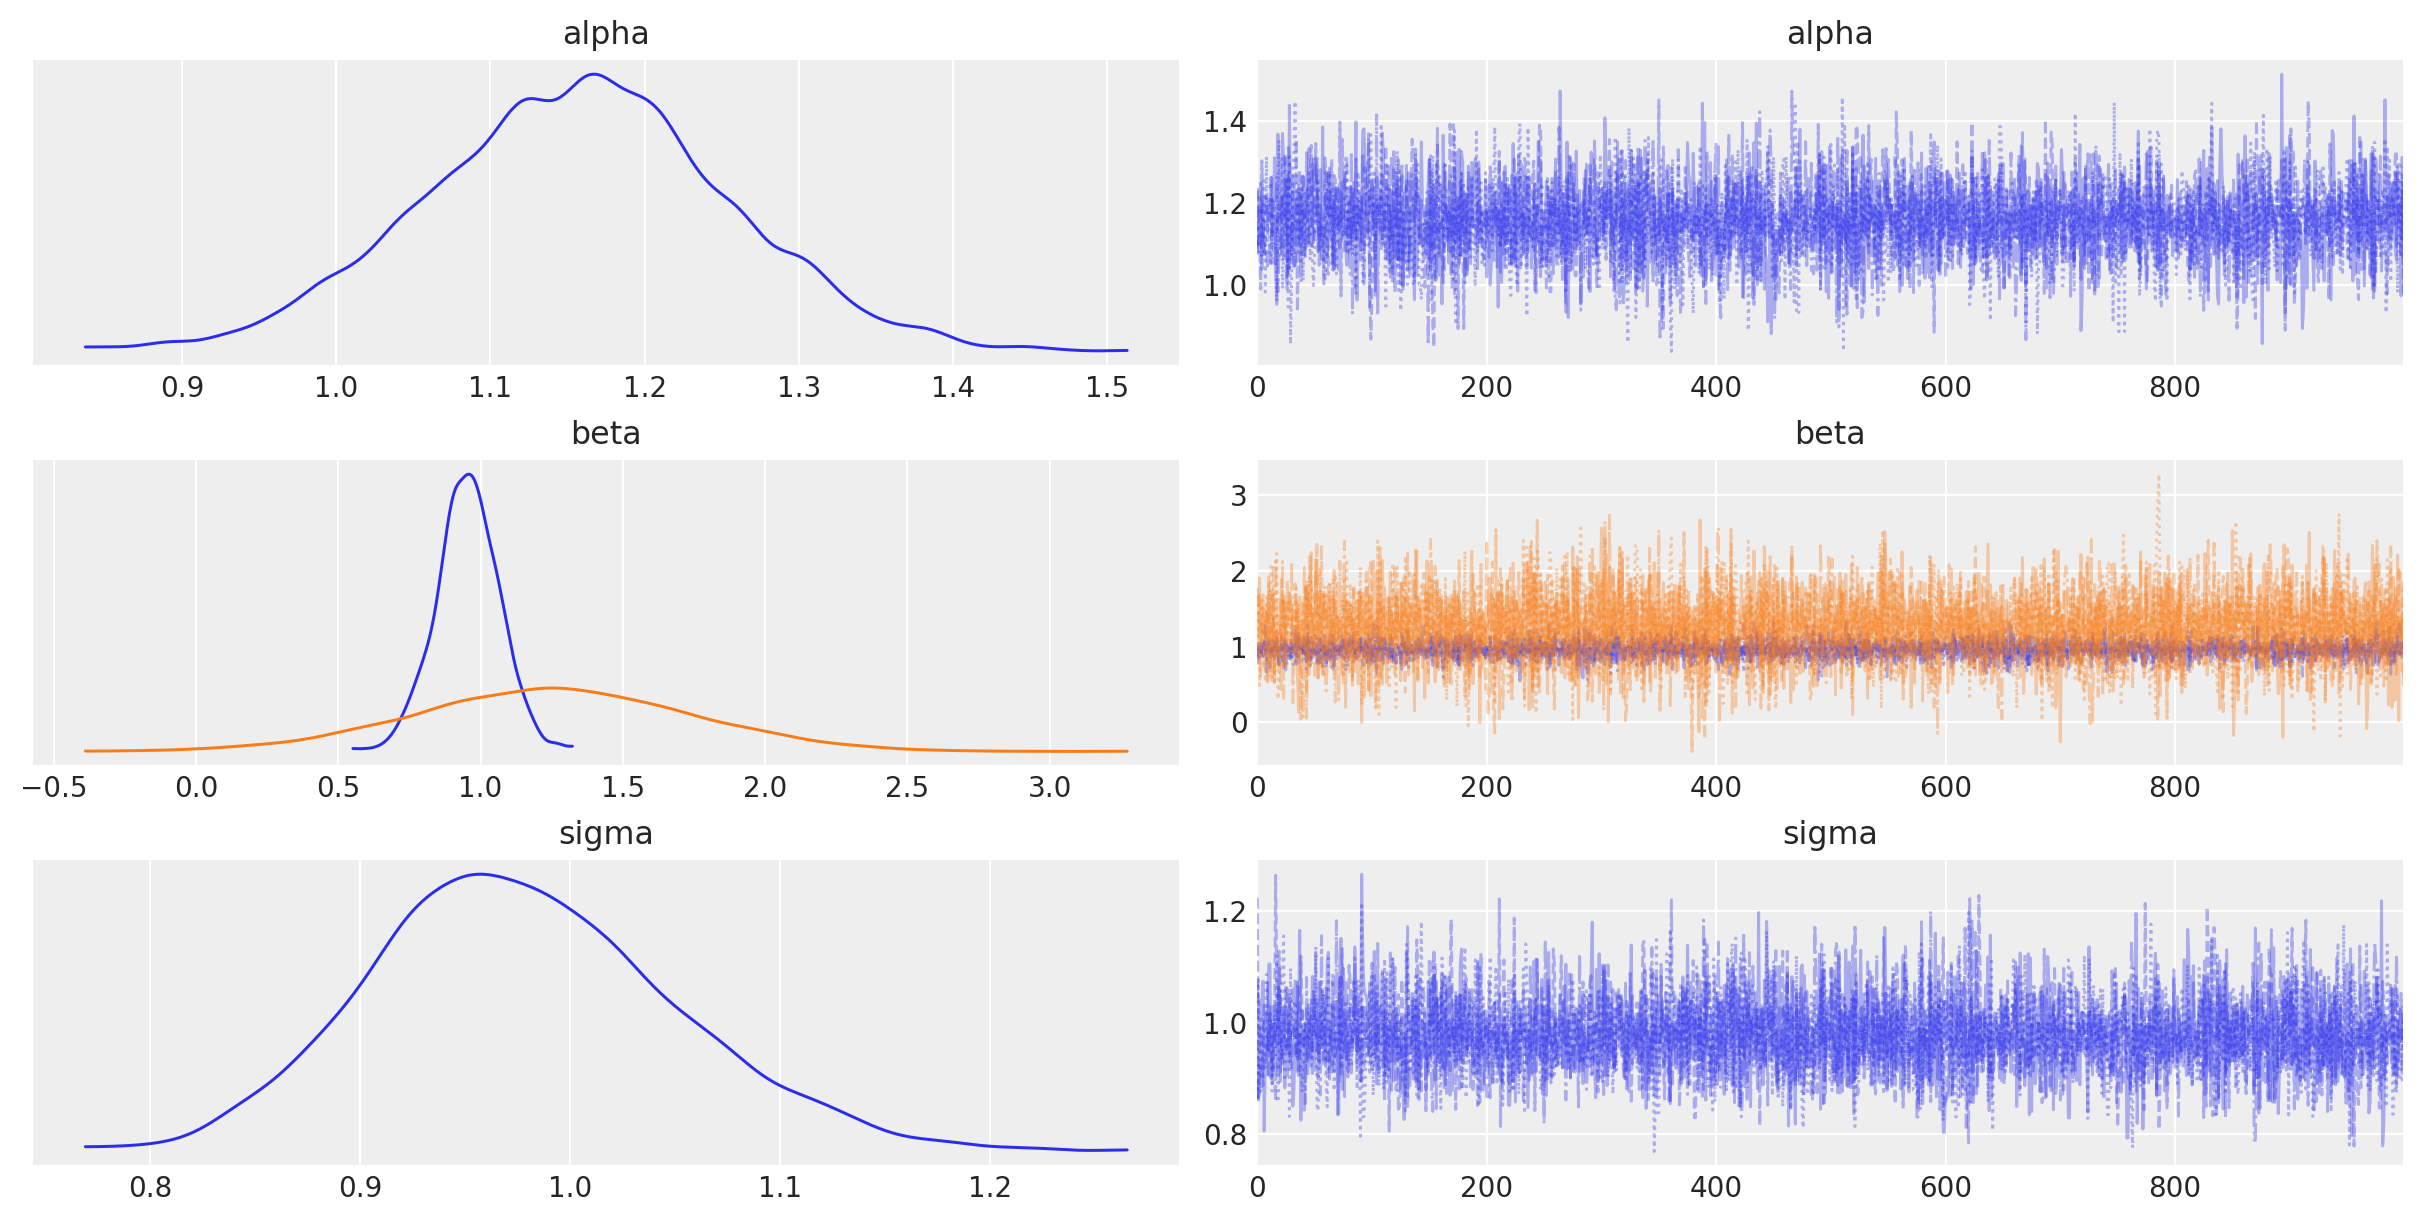

In [12]:
# combined=True combines the chains
az.plot_trace(idata, combined=True);

The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. The `beta` variable, being vector-valued, produces two density plots and two trace plots, corresponding to both predictor coefficients.

In addition, the {mod}`~arviz.summary` function provides a text-based output of common posterior statistics:

In [10]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.16,0.10,0.96,1.33,0.00,0.0,5514.77,3377.24,1.0
beta[0],0.95,0.11,0.73,1.15,0.00,0.0,6249.38,3485.80,1.0
beta[1],1.25,0.48,0.38,2.19,0.01,0.0,6312.74,3280.98,1.0
sigma,0.98,0.07,0.85,1.12,0.00,0.0,6300.17,3020.30,1.0
